In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set("".join(words))))
stoi  = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos  = {i:s for s,i in stoi.items()}
vocal_size = len(itos)

In [2]:
# building dataset

block_size =3

def build_dataset(words, block_size=3):
    X , Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            X.append(context)
            Y.append(stoi[ch])
            # print(f"{''.join([itos[i] for i in context])} -> {ch}") 

            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1], block_size=3)
Xdv, Ydv = build_dataset(words[n1:n2], block_size=3)
Xte, Yte = build_dataset(words[n2:], block_size=3)

print(Xtr.shape, Ytr.shape, Xdv.shape, Ydv.shape, Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625]) torch.Size([22655, 3]) torch.Size([22655]) torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# building MLP with rand initialization

n_embd = 2
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocal_size, n_embd ,                    generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g)
B1 = torch.randn(n_hidden,                              generator=g)
W2 = torch.randn((n_hidden, vocal_size),                generator=g)
B2 = torch.randn(vocal_size,                            generator=g)

parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad_()

print(sum(p.nelement() for p in parameters))

3481


In [6]:
batch_size = 32
steps = 200000
lossi = []

for i in range(steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
        

      0/ 200000:  18.2182
  10000/ 200000:  2.9901
  20000/ 200000:  2.3805
  30000/ 200000:  2.7608
  40000/ 200000:  2.3949
  50000/ 200000:  2.2300
  60000/ 200000:  2.8805
  70000/ 200000:  2.3401
  80000/ 200000:  2.0514
  90000/ 200000:  2.4229
 100000/ 200000:  2.3707
 110000/ 200000:  2.3916
 120000/ 200000:  2.0378
 130000/ 200000:  2.2661
 140000/ 200000:  2.2305
 150000/ 200000:  2.3041
 160000/ 200000:  2.3768
 170000/ 200000:  2.1656
 180000/ 200000:  2.1754
 190000/ 200000:  2.0359


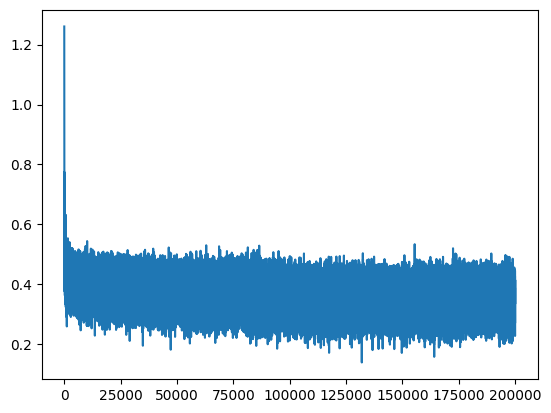

In [7]:
plt.plot(lossi)

In [8]:
torch.no_grad()
def print_overall_loss(split):
    x , y = {'train':(Xtr, Ytr), 'dev':(Xdv, Ydv), 'test':(Xte, Yte)}[split]
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")

print_overall_loss('train')
print_overall_loss('dev')    

train loss: 2.2517
dev loss: 2.2551


In [ ]:
# sampling from model
g = torch.Generator().manual_seed(2147483647 + 10) 

for i in range(10):
    out = ''
    context = [0] * block_size
    while True:
        x = torch.tensor([context])
        x_emb = C[x]
        h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
        h = torch.tanh(h1)
        logits = h @ W2 + B2
        p = F.softmax(logits, dim=1)
        # predicted_char = itos[p]
        # out += predicted_char
        # if p == 0:
        #     print(f"{i} : {out}")
        #     break
        # context = context[1:] + [c]
        
    